In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
batch_size = 32

In [4]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_dir = '../input/facial-age/face_age/face_age'
files = os.listdir(train_dir)
#files = files.remove('face_age')
print(len(files))


99


In [6]:
d = '../input/facial-age/face_age/face_age/110'
print(d.split('/')[-1])
for i in files:
    if i in d.split('/')[-1]:
        print(int(i))

110
110


In [7]:
classes = []

for i in os.listdir(train_dir):
    classes.append(i)
classes = sorted(classes)
print(len(classes))

99


In [8]:
class AgeDataset(Dataset):
    def __init__(self,directory,file_list,transform = None):
        self.directory = directory
        self.file_list = file_list
        self.transform = transform
        self.k = k
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.file_list[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        for i in classes:
            if i == self.directory.split('/')[-1]:
                self.label = int(i)
                
            else:
                continue
                
        img = img.numpy()
        return img.astype('float32'), self.label

In [9]:
'''
k=0
working_ds = None
for c in classes:
    directory = os.path.join(train_dir,c)
    file_list = os.listdir(directory)
    if c in directory.split('/')[-1]:
        print(c)
        k=k+1
    new = AgeDataset(directory,file_list,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))
print(k)'''


"\nk=0\nworking_ds = None\nfor c in classes:\n    directory = os.path.join(train_dir,c)\n    file_list = os.listdir(directory)\n    if c in directory.split('/')[-1]:\n        print(c)\n        k=k+1\n    new = AgeDataset(directory,file_list,train_transform)\n    \n    if working_ds == None:\n        working_ds = new\n    else:\n        working_ds = ConcatDataset([working_ds,new])\nprint(len(working_ds))\nprint(k)"

In [10]:
working_ds = datasets.ImageFolder(root = os.path.join(train_dir),transform = train_transform)
print(len(working_ds))
train_ds,val_ds = random_split(working_ds,[9000,778])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=32, 
                                          shuffle=False)

9778


In [11]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [12]:
#train_ds,val_ds = train_val_split(working_ds)

In [13]:
i,l = next(iter(train_loader))
print(l.shape)

torch.Size([32])


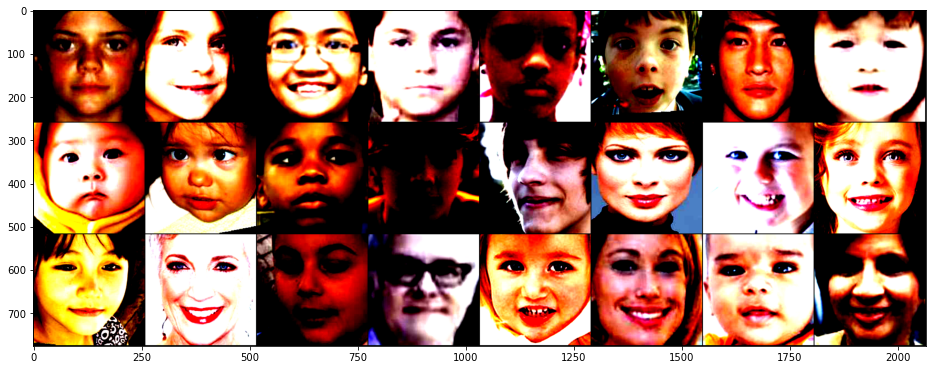

In [14]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [15]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images).float()
      
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [16]:


def train(model, criterion, optimizer,sch,num_epochs):
  for epoch in range(num_epochs): 
      print("Epoch:",epoch+1)
      running_loss = 0.0
      
      for i,data in enumerate(train_loader,0):
          inputs,labels = data
          
          
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          optimizer.zero_grad()
    
          output = model(inputs)
          output = output.to(device)
          loss = criterion(output, labels)
    
          loss.backward()
          optimizer.step()
          
          
          running_loss += loss.item()
    
    
          if i % 50 == 49:    
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
              running_loss = 0.0
      sch.step()  
      print('Epoch:', epoch+1,'LR:', sch.get_last_lr())
      print("EPOCH OVER")
      train_acc = model_eval(train_loader,model)
      with torch.no_grad():
        test_acc = model_eval(val_loader,model)
      print("############################")
      print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
      print("############################")
      print("")
  return model
    


In [17]:
vgg16_backbone = models.vgg16(pretrained=True)
i=0
for param in vgg16_backbone.parameters():
    i=i+1
    param.requires_grad = True
    #if(i >=24):
        #param.requires_grad = True
    #else:
        #param.requires_grad = False
#num_ftrs = vgg16_backbone.fc.in_features
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(*list(vgg16_backbone.features.children()))

        self.drop1 = nn.Dropout(0.3)
        #self.drop2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(32768,1024)
        #self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(1024,1)
        self.final = nn.Sigmoid()
    def forward(self,x):
    
        x = self.features(x)

        x = x.view(x.shape[0],32768)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        #x = F.relu(self.fc2(x))
       
        #x = self.drop2(x)
        x = self.fc3(x)
        #x = self.drop1(x)
        #x = F.relu(self.fc4(x))
        x = self.final(x)

        return x       


criterion = nn.CrossEntropyLoss()  
    
vgg_model = VGG16()
vgg_model = vgg_model.to(device)



#optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
print(vgg_model)



VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [18]:
from tqdm import tqdm
def train(loader, model, optimizer, criterion, scaler):
    loop = tqdm(loader) #For the progress bar
    
    for idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.type(torch.float32).unsqueeze(1).to(device)
        targets = 0.01 + targets/100
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        #lr.append(get_lr(optimizer))
        loop.set_postfix(loss = loss.item())

In [19]:
from tqdm import tqdm
def train1( loader, model, optimizer, criterion, scaler):
        loop = tqdm(loader) #For the progress bar
    
    #for idx, (data, targets) in enumerate(loop):
        data, targets = next(iter(train_loader))
        data = data.to(device)
        targets = targets.float().to(device)
        
        
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        
        loop.set_postfix(loss = loss.item())

In [20]:
d,l = next(iter(train_loader))
d = d.to(device)
l = l.to(device)
x = vgg_model(d).unsqueeze(1)
print(x.shape)
print(l.shape)

torch.Size([32, 1, 1])
torch.Size([32])


In [21]:
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
sch = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    print(f"epoch:{epoch+1}/{NUM_EPOCHS}")
    print("LR:",sch.get_last_lr())
    train(train_loader, vgg_model, optimizer, criterion, scaler)
    sch.step()
    print("EPOCH OVER")

  0%|          | 0/282 [00:00<?, ?it/s]

epoch:1/20
LR: [0.0001]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:2/20
LR: [0.0001]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:3/20
LR: [0.0001]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:4/20
LR: [0.0001]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:5/20
LR: [1e-05]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:6/20
LR: [1e-05]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:7/20
LR: [1e-05]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:8/20
LR: [1e-05]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:9/20
LR: [1.0000000000000002e-06]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:10/20
LR: [1.0000000000000002e-06]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:11/20
LR: [1.0000000000000002e-06]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:12/20
LR: [1.0000000000000002e-06]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:13/20
LR: [1.0000000000000002e-07]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:14/20
LR: [1.0000000000000002e-07]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:15/20
LR: [1.0000000000000002e-07]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:16/20
LR: [1.0000000000000002e-07]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:17/20
LR: [1.0000000000000004e-08]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:18/20
LR: [1.0000000000000004e-08]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:19/20
LR: [1.0000000000000004e-08]


  0%|          | 0/282 [00:00<?, ?it/s]

EPOCH OVER
epoch:20/20
LR: [1.0000000000000004e-08]


100%|██████████| 282/282 [02:17<00:00,  2.05it/s, loss=0.000293]

EPOCH OVER


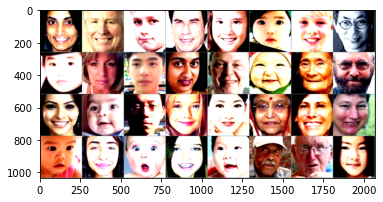

[29, 56, 14, 59, 13, 3, 14, 52, 4, 59, 22, 26, 57, 2, 85, 59, 26, 1, 32, 8, 26, 66, 57, 52, 1, 15, 1, 16, 1, 72, 90, 8]
[31, 59, 13, 53, 8, 3, 5, 50, 5, 59, 17, 27, 62, 2, 84, 69, 23, 0, 33, 13, 26, 78, 48, 42, 0, 22, 0, 18, 1, 68, 80, 10]


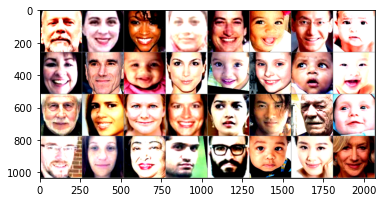

[52, 33, 21, 29, 39, 2, 33, 1, 59, 57, 1, 23, 3, 9, 1, 1, 69, 25, 45, 27, 22, 24, 79, 1, 33, 32, 72, 24, 32, 1, 25, 66]
[53, 36, 19, 36, 42, 7, 41, 1, 41, 53, 0, 27, 1, 9, 2, 0, 69, 24, 21, 29, 24, 27, 84, 3, 42, 34, 71, 25, 43, 0, 20, 66]


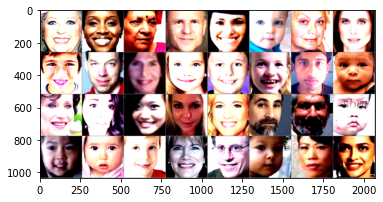

[75, 30, 62, 54, 23, 2, 70, 26, 10, 36, 69, 8, 9, 8, 25, 1, 59, 20, 19, 24, 24, 39, 58, 1, 4, 1, 4, 52, 53, 3, 38, 21]
[62, 33, 61, 28, 21, 1, 71, 29, 5, 30, 44, 5, 5, 6, 28, 0, 53, 16, 14, 23, 24, 47, 62, 7, 5, 1, 6, 51, 55, 1, 33, 23]


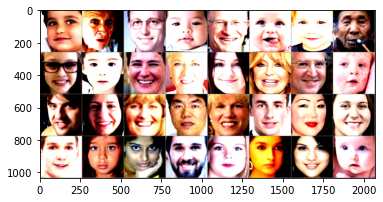

[4, 85, 39, 1, 58, 1, 2, 88, 14, 4, 36, 66, 17, 66, 46, 3, 33, 30, 54, 42, 39, 20, 38, 19, 17, 8, 24, 26, 4, 20, 15, 1]
[2, 79, 36, 1, 50, 0, 3, 83, 22, 3, 34, 68, 18, 65, 54, 4, 31, 37, 50, 44, 52, 24, 50, 21, 21, 9, 18, 27, 12, 20, 16, 0]


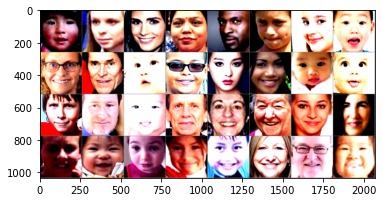

[21, 32, 25, 35, 32, 9, 12, 4, 42, 58, 1, 14, 22, 19, 1, 1, 12, 46, 1, 75, 45, 85, 17, 40, 9, 1, 7, 9, 4, 59, 52, 4]
[4, 22, 20, 34, 33, 4, 9, 1, 40, 67, 3, 15, 20, 21, 0, 0, 23, 43, 1, 72, 50, 85, 28, 32, 29, 2, 4, 11, 8, 51, 59, 4]


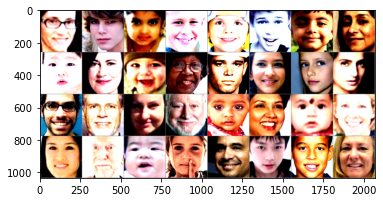

[32, 18, 4, 13, 4, 16, 4, 42, 2, 52, 2, 52, 22, 25, 13, 21, 26, 52, 30, 59, 1, 48, 1, 32, 30, 85, 1, 9, 39, 15, 14, 38]
[34, 20, 6, 9, 4, 14, 5, 41, 1, 45, 3, 58, 25, 34, 8, 27, 32, 46, 32, 66, 0, 40, 1, 46, 22, 81, 1, 11, 43, 18, 8, 41]


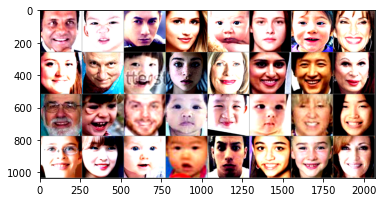

[36, 4, 29, 18, 1, 17, 2, 59, 20, 67, 3, 16, 56, 32, 26, 79, 71, 4, 36, 1, 3, 2, 39, 18, 14, 20, 1, 1, 22, 16, 8, 48]
[44, 5, 16, 18, 0, 16, 2, 56, 24, 62, 8, 13, 71, 22, 32, 71, 57, 8, 36, 1, 3, 0, 54, 17, 10, 17, 0, 1, 31, 15, 11, 47]


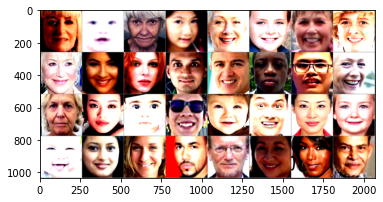

[57, 1, 85, 8, 76, 9, 66, 15, 66, 22, 24, 29, 45, 15, 35, 72, 85, 30, 1, 16, 1, 26, 30, 4, 1, 22, 49, 27, 58, 26, 52, 60]
[60, 0, 67, 11, 71, 8, 47, 13, 68, 20, 23, 26, 45, 14, 29, 83, 81, 20, 1, 22, 2, 35, 38, 6, 1, 27, 46, 31, 55, 26, 26, 69]


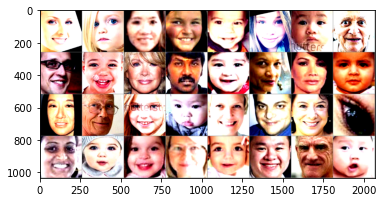

[22, 3, 29, 16, 2, 18, 3, 88, 36, 2, 65, 30, 1, 56, 30, 1, 62, 72, 10, 1, 35, 32, 65, 1, 38, 1, 4, 39, 1, 40, 70, 1]
[20, 1, 29, 13, 1, 12, 0, 91, 38, 3, 62, 40, 2, 45, 32, 1, 49, 77, 15, 0, 27, 25, 58, 39, 33, 3, 1, 43, 3, 18, 65, 0]


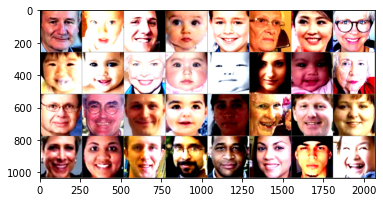

[52, 3, 26, 1, 9, 85, 36, 56, 3, 2, 72, 1, 1, 26, 1, 85, 52, 53, 36, 2, 33, 67, 45, 35, 59, 29, 36, 30, 39, 27, 18, 7]
[55, 4, 46, 0, 5, 76, 29, 59, 1, 0, 71, 0, 1, 20, 0, 87, 49, 61, 31, 5, 31, 71, 44, 48, 39, 26, 29, 33, 36, 29, 25, 23]


In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
i=0
for x,y in val_loader:
    i = i+1
    x=x.cuda()
    y=.01+y.reshape((32,1)).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x.cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,32).tolist()[0])
    print(z.reshape(1,32).tolist()[0])
    if(i == 10):
        break
    

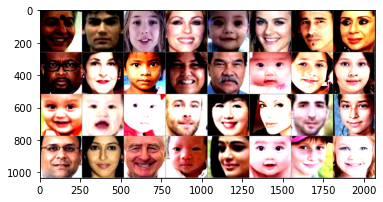

[59, 1, 14, 29, 1, 26, 26, 49, 49, 59, 4, 29, 65, 1, 8, 8, 1, 1, 1, 29, 49, 24, 26, 13, 43, 26, 82, 1, 27, 1, 10, 4]
[63, 10, 13, 32, 1, 22, 27, 50, 49, 69, 2, 33, 64, 1, 10, 14, 0, 1, 2, 23, 47, 24, 30, 11, 41, 25, 76, 0, 25, 0, 7, 3]


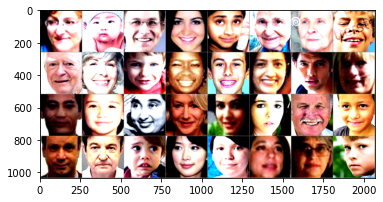

[53, 1, 36, 26, 5, 89, 85, 14, 72, 59, 4, 27, 15, 32, 21, 56, 33, 9, 32, 66, 26, 24, 65, 10, 49, 75, 3, 29, 12, 38, 56, 10]
[54, 4, 36, 26, 8, 88, 85, 10, 72, 60, 4, 29, 14, 34, 20, 55, 32, 3, 31, 66, 23, 25, 62, 6, 51, 74, 5, 28, 15, 43, 51, 9]


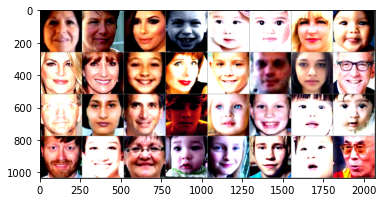

[69, 52, 23, 4, 1, 1, 56, 2, 56, 65, 9, 59, 9, 33, 18, 58, 42, 30, 42, 13, 4, 8, 3, 1, 36, 24, 69, 3, 10, 16, 2, 62]
[66, 51, 25, 6, 0, 1, 55, 0, 57, 61, 8, 58, 10, 35, 15, 57, 41, 33, 46, 13, 1, 5, 3, 1, 39, 29, 70, 1, 8, 16, 1, 66]


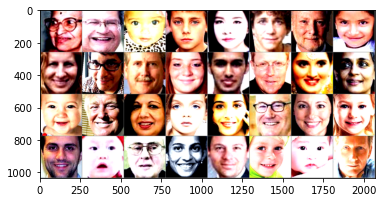

[72, 52, 2, 9, 33, 52, 58, 5, 32, 35, 56, 16, 26, 52, 21, 48, 1, 67, 56, 8, 29, 52, 29, 4, 29, 1, 77, 32, 33, 4, 1, 39]
[66, 55, 0, 10, 28, 46, 57, 6, 35, 32, 48, 12, 25, 54, 21, 43, 2, 67, 55, 5, 26, 56, 34, 5, 32, 0, 73, 28, 34, 3, 1, 39]


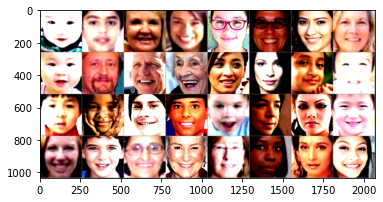

[1, 17, 60, 22, 14, 36, 20, 36, 2, 42, 67, 95, 27, 32, 5, 4, 5, 4, 17, 24, 7, 32, 26, 4, 33, 8, 39, 72, 39, 45, 25, 24]
[0, 13, 62, 24, 10, 38, 21, 37, 0, 47, 67, 93, 25, 28, 12, 9, 4, 4, 15, 25, 5, 29, 26, 5, 32, 7, 44, 74, 42, 37, 27, 20]


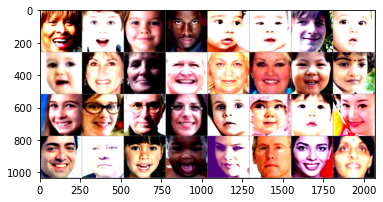

[67, 10, 8, 19, 1, 1, 16, 1, 1, 59, 70, 58, 70, 38, 4, 5, 14, 29, 64, 39, 3, 1, 2, 26, 35, 66, 4, 1, 16, 49, 27, 53]
[65, 6, 2, 21, 3, 1, 11, 1, 1, 53, 67, 58, 70, 37, 5, 10, 12, 25, 69, 34, 2, 3, 0, 27, 34, 65, 11, 1, 17, 46, 27, 58]


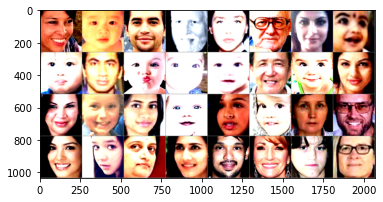

[33, 2, 26, 65, 26, 72, 33, 2, 2, 21, 1, 1, 1, 70, 1, 24, 32, 9, 24, 1, 15, 1, 52, 35, 24, 14, 56, 26, 26, 59, 15, 53]
[29, 0, 30, 61, 26, 76, 37, 15, 0, 25, 1, 2, 0, 67, 1, 26, 33, 10, 25, 1, 12, 4, 50, 33, 19, 12, 50, 31, 24, 58, 14, 42]


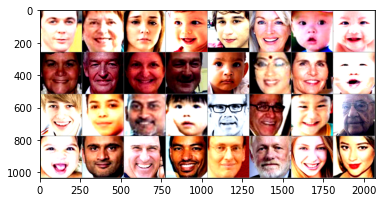

[39, 51, 23, 2, 19, 59, 1, 1, 66, 75, 40, 56, 2, 39, 58, 2, 16, 9, 48, 4, 52, 58, 4, 79, 1, 35, 62, 29, 39, 70, 18, 21]
[43, 46, 20, 1, 16, 55, 0, 0, 58, 73, 44, 57, 1, 48, 57, 1, 21, 9, 49, 2, 53, 58, 3, 83, 2, 34, 61, 32, 34, 67, 15, 21]


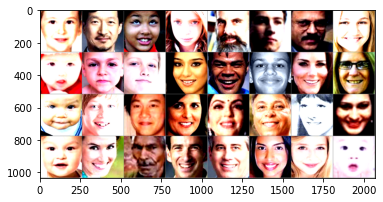

[8, 52, 13, 9, 48, 19, 52, 16, 1, 7, 14, 24, 39, 16, 36, 42, 1, 14, 29, 40, 32, 49, 19, 26, 2, 27, 75, 36, 49, 24, 14, 1]
[11, 48, 11, 10, 51, 21, 50, 13, 1, 6, 11, 21, 39, 19, 37, 42, 0, 12, 29, 43, 36, 53, 15, 29, 1, 28, 68, 37, 47, 22, 13, 0]


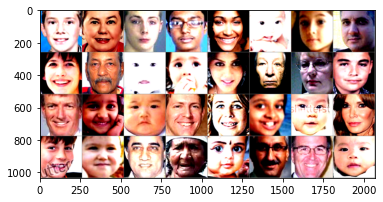

[14, 54, 16, 18, 24, 1, 4, 45, 39, 76, 1, 2, 24, 79, 49, 17, 58, 3, 1, 33, 17, 12, 1, 66, 10, 4, 56, 85, 1, 60, 52, 1]
[14, 59, 23, 19, 26, 2, 2, 46, 37, 76, 2, 0, 21, 85, 54, 12, 51, 2, 0, 37, 17, 4, 0, 68, 11, 4, 50, 83, 0, 56, 49, 0]


In [23]:
i=0
for x,y in train_loader:
    i = i+1
    x=x.cuda()
    y=.01+y.reshape((32,1)).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x.cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,32).tolist()[0])
    print(z.reshape(1,32).tolist()[0])
    if(i == 10):
        break